# 模型驗證的方法

## 重點
* Pipeline
* K-fold cross-validation
* Learning Curve
* Validation Curve
* nested cross-validation
* confusion matrix


以 Breast Cancer Wisconsin (Diagnostic) Data Set 為例

資料來源：
* https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html


資料描述：

Diagnosis (M = malignant惡性的, B = benign良性的)

Samples per class

212(M),357(B)

## 實作步驟
* Step1.載入基本套件與資料
* Step2.觀察資料
* Step3.資料前處理
* Step4.建立模型
* Step5.模型訓練
* Step6.訓練成效檢視

### Step1.載入基本套件與資料

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#讀入 breast_cancer 資料集
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data #sample(樣本)資料
y = data.target #Lable(標籤)資料

### Step2.觀察資料

In [2]:
print("樣本資料數量",len(X))
print("樣本資料型態",type(X))
print("\n")
print("標籤資料數量",len(y))
print("標籤資料型態",type(y))

樣本資料數量 569
樣本資料型態 <class 'numpy.ndarray'>


標籤資料數量 569
標籤資料型態 <class 'numpy.ndarray'>


In [3]:
X

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

由於資料集中的樣本和標籤資料都是ndarray的格式，也就是被向量化了，不容易被人所理解。因此透過pandas的工具轉換成結構化資料，更容易從資料中探索出更多線索。

In [4]:
#將樣本與標籤資料從 ndarray 轉換成 DataFrame
pandas_x = pd.DataFrame(X) 
pandas_y = pd.DataFrame(y)

Data = pd.concat([pandas_x, pandas_y], axis=1) #將樣本和標籤資料併成一個表格
Data.head(5) #檢視前5筆資料

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,0
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
Data.iloc[:,30].unique() #顯示類別

array([0, 1], dtype=int64)

從DataFrame中，我們得知標籤數量為30。各個特徵的尺度也不同。因此在後續的模型訓練前，要先進行資料正規化。

另外透過unique語法，我們得知類別為'0','1'，所以這是一個二元分類的問題。

從資料來看，總計有30個特徵，各個特徵的尺度也不同。因此在後續的模型訓練前，要先進行資料正規化。

In [6]:
#檢視各類別中的數量
Data.iloc[:,30].value_counts()

1    357
0    212
Name: 0, dtype: int64

和原始資料描述的相符

B良性:357

M惡性:212

### Step3.資料前處理 & Step4.建立模型 & Step5.模型訓練

使用pipeline技巧將3個步驟合併

In [7]:
#要將資料餵入模型前，資料要轉成 ndarray，所以如果是 DataFrame中的值，要再透過 ".values"轉換。
X = pandas_x.values
y = pandas_y.values

#將資料切分成訓練資料集與測試資料集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

In [8]:
from sklearn.preprocessing import StandardScaler #標準化套件
from sklearn.decomposition import PCA #PCA降維套件
from sklearn.linear_model import LogisticRegression #模型
from sklearn.pipeline import make_pipeline #pipeline套件

#將正規化、PCA降維與模型建立以pipeline整合
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))

#模型訓練 
pipe_lr.fit(X_train, y_train)

C:\Users\reclu\Anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=1,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

### 關於Pipeline的補充資料

Pipeline from sklearn : https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

![Image of Yaktocat](https://frankchen.xyz/images/15231783974167.jpg)
<source> http://frankchen.xyz/2018/04/08/pipeline-in-machine-learning/

### Step6.訓練成效檢視

In [9]:
y_pred = pipe_lr.predict(X_test)
print("Test Accuracy: %.2f" % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.96


In [10]:
#當資料少時，透過交叉驗證可以檢視模型的效能
#交叉驗證
from sklearn.model_selection import cross_val_score #交叉驗證計分器的模組
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=2) #參數依序為分類器(模型)、樣本訓練資料、標籤訓練資料，cv(折數)、n_jobs(調用的CPU數量)
print('CV Acc:%s', scores) #顯示每一折的準確率
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) #顯示平均準確率與標準差

CV Acc:%s [0.97826087 0.93478261 0.95652174 0.93478261 0.91304348 0.95555556
 0.93333333 0.95555556 0.93333333 0.97777778]

CV accuracy: 0.947 +/- 0.020


In [11]:
pipe_lr.score(X_test, y_test) #以測試資料檢視模型的準確率

0.956140350877193

### Step7.模型優化

### Learning Curve

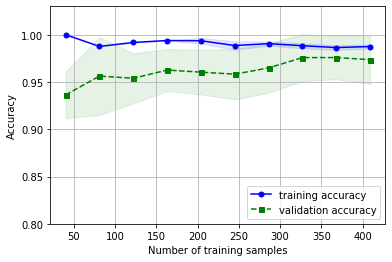

In [12]:
from sklearn.model_selection import learning_curve #Learning Curve套件

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2',random_state=1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr ,X=X_train, y=y_train, train_sizes = np.linspace(0.1,1.0,10),\
                                                        cv=10, n_jobs=2)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

#繪製train標準差之區間面積
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

#繪製test標準差之區間面積
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.1, color='green')

plt.grid() #開啟網格
plt.xlabel('Number of training samples') #x軸名稱
plt.ylabel('Accuracy') #y軸名稱
plt.legend(loc='lower right') #圖例
plt.ylim([0.8, 1.03]) #設定y軸的範圍，min:0.8, max:1.03
plt.show()

### Validation Curve

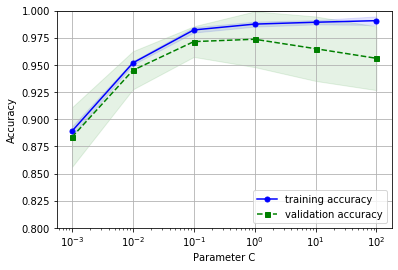

In [13]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] #設定Logistic Regression中的C(反正規化參數)之範圍
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10,n_jobs=2)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.1,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.1, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

從圖表來看，C介於0.1~1間的模型績效會不錯。

In [14]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(C=1,random_state=1))
pipe_lr.fit(X_train, y_train)
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=2)
print('CV Acc:%s', scores)
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
print('\nTest Acc',pipe_lr.score(X_test, y_test))

CV Acc:%s [0.93478261 1.         0.95652174 1.         0.97826087 1.
 0.97777778 0.95555556 0.93333333 1.        ]

CV accuracy: 0.974 +/- 0.026

Test Acc 0.9912280701754386


C:\Users\reclu\Anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


輸入新的參數組合後，測試資料用於新模型的準確度已達99%，優於改善前的0.95

### 換其他模型試試看，以SVM為例

In [15]:
#使用暴力法找到SVM中最佳的參數組合，再用於模型訓練

from sklearn.model_selection import GridSearchCV #網格搜尋法，即暴力法
from sklearn.svm import SVC #SVM模型

pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1)) #建立pipeline

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] #參數組合範圍

#以dict的資料型態，設定 linear與 rbf kernel 的最佳參數組合
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

#利用 GridSearch 建立訓練模型，尋找最佳參數組合
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

#將訓練資料代入模型訓練
gs = gs.fit(X_train, y_train)

print(gs.best_score_) #顯示最佳的模型準確度
print(gs.best_params_) #顯示最佳的參數組合

0.9758454106280192
{'svc__C': 10.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


C:\Users\reclu\Anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
best_svc = gs.best_estimator_ #取得最佳參數組合的模型
best_svc.fit(X_train, y_train) #重新訓練

#交叉驗證
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=best_svc, X=X_train, y=y_train, cv=10, n_jobs=2)

print('CV Acc:%s', scores)
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

#用測試資料集進行測試
print('\nTest Acc:',best_svc.score(X_test, y_test))

C:\Users\reclu\Anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CV Acc:%s [1.         0.97826087 0.95652174 0.95652174 0.97826087 0.97777778
 0.97777778 0.97777778 0.95555556 1.        ]

CV accuracy: 0.976 +/- 0.015

Test Acc: 0.9824561403508771


### 巢狀交叉驗證

![Image of Yaktocat](https://miro.medium.com/max/15220/1*8WAHvOZkLwtwFLwWPVNhow.png)
<source:https://towardsdatascience.com/validating-your-machine-learning-model-25b4c8643fb7>

In [17]:
from sklearn.model_selection import GridSearchCV #網格搜尋法，即暴力法
from sklearn.svm import SVC #SVM模型

pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1)) #建立pipeline

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] #參數組合範圍

#以dict的資料型態，設定 linear與 rbf kernel 的最佳參數組合
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

#內折2折，選擇模型用
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,n_jobs=-1)

#外折5折，測試模型的 Variance
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5,n_jobs=-1)


#將訓練資料代入模型訓練
gs = gs.fit(X_train, y_train)

print(gs.best_score_) #顯示最佳的模型準確度
print(gs.best_params_) #顯示最佳的參數組合
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

0.9736069248009892
{'svc__C': 1.0, 'svc__kernel': 'linear'}
CV accuracy: 0.971 +/- 0.011


C:\Users\reclu\Anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
best_svc = gs.best_estimator_ #取得最佳參數組合的模型
best_svc.fit(X_train, y_train) #重新訓練
best_svc.score(X_test, y_test) #用測試資料集進行測試

C:\Users\reclu\Anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9912280701754386

### Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix #confusion_matrix 模組
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confusion_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred) #參數為(真實資料, 預測資料)
print(confusion_matrix)

[[40  2]
 [ 0 72]]


C:\Users\reclu\Anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


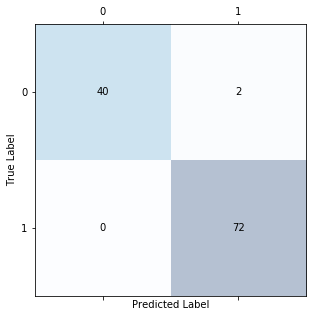

In [20]:
fig, ax = plt.subplots(figsize=(5, 5)) #設定圖表大小
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i, s=confusion_matrix[i, j], verticalalignment='center', horizontalalignment='center') #設定圖表中的資料內容
    
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision:', precision_score(y_true = y_test, y_pred = y_pred))
print('\nRecall:', recall_score(y_true = y_test, y_pred = y_pred))
print('\nf1_score:', f1_score(y_true = y_test, y_pred = y_pred))

Precision: 0.972972972972973

Recall: 1.0

f1_score: 0.9863013698630138
